# PS2

## Question 3


## Algoritm

HJB For Unemployer Workers

$\rho V_u(x) = \frac{\lambda \beta}{\rho + \delta} \int_\mathcal{Y} p(\bar{z}) * (\omega_z(\bar{z})f(x,y) -\rho V_u(x) - \rho V_v(y) ) v(y) $


HJB For Vacant firms 

$\rho V_v(y) = \frac{\lambda (1-\beta)}{\rho + \delta} \int_\mathcal{X} p(\bar{z}) * (\omega_z(\bar{z})f(x,y) -\rho V_u(x) - \rho V_v(y) ) u(x) $



1. Start with some initial estimate and guess about the u(x), v(y), V_u(x) and V_v(y). in the outerloop. 
2. Inner Loop
   1. Estimate the value of zbar such that S(z,x,y) >= 0. Estiamte this zbar across all the grid points across the x_grid X y_grid. 
        $$\bar{z} = \rho (V_u(X) + V_v(y))/f(x,y)$$
   2. Use this zbar to get the p(zbar) and \omega_z(zbar) [Conditonal expected value] as we know z has pareto distribution with the shape parameter estimated earlier. 
   3. Use the $\bar{z}$ and $\omega_z(\bar{z})$, use the HJB equation for unemployed workers and vacant firms to form new estimate of $V'_u(x), V'_v(y)$.
   4. Iterate till the $|V'_u(x) - V_u(x)| < \epsilon$ and $|V'_v(y) - V_v(y)| < \epsilon$
3. Compute the new $u'(x) = \frac{\delta}{\delta + \lambda \int_\mathcal{Y} p(\bar{z}) v(y) }$ and new $v'(y) = \frac{\delta}{\delta + \lambda \int_\mathcal{X} p(\bar{z}) u(x) }$
4. Check for the convergence in $u(x), v(y)$
   1. If $|u'(x) - u(x)| < \epsilon$ and $|v'(y) - v(y)| < \epsilon$ stop
   2. Else set u(x) = u'(x) and v(y) = v'(y), and go to the step 1 of the outer loop. 
   

In [55]:
## Loading required packages
using Roots
using Distributions
using Plots

### Functions

In [56]:

"""
Production function f(x,y) in vectorized form
CES production function with elasticity ζ
"""
function compute_f_xy(x_grid, y_grid, ζ)
    return (0.5*x_grid.^((ζ-1)/ζ) .+ 0.5*y_grid'.^((ζ-1)/ζ)).^(ζ/(ζ-1))
end

"""
Threshold productivity z̄(x,y) = ρ(V_u(x) + V_v(y))/f(x,y)
Ensures z̄ >= z_min to maintain valid Pareto distribution
"""
function compute_z_bar(V_u, V_v, ρ, f_xy)
    z_bar = ρ .* ((V_u .+ V_v')./f_xy)
    z_bar = max.(z_bar, z_min * 1.001)  # Ensure z̄ >= z_min
    return z_bar
end

"""
Pareto survivor function: P(z >= z̄) = (z_min/z̄)^α
"""
function pareto_survivor(z_bar, z_min = z_min, α = α_manual_solution)
    return (z_min ./z_bar).^α
end

"""
Pareto conditional mean: E[z | z >= z̄] = (α/(α-1)) * z̄
"""
function pareto_conditional_mean(z_bar, α = α_manual_solution)
    return ((α/(α-1)) .*z_bar)
end

pareto_conditional_mean

### Model Parameters

In [57]:

# Utility Parameters
ρ = 0.05    # Discount rate
β = 0.5     # Worker's bargaining power
λ = 10      # Meeting rate
δ = 0.25    # Separation rate
ζ = 0.5     # Elasticity of substitution

# Pareto Parameters
z_min = 1.0         # Minimum productivity
σ_target = 0.1      # Target standard deviation

0.1

In [58]:
#=============================================================================
    2. SOLVE FOR PARETO SHAPE PARAMETER
=============================================================================#

# Solve for α (shape parameter) given target standard deviation
# Standard deviation formula: σ = z_min * sqrt(α / ((α-1)^2 * (α-2)))
function pareto_std_cubic(α)
    return z_min^2 * α - σ_target^2 * (α - 1)^2 * (α - 2)
end

α_manual_solution = find_zero(pareto_std_cubic, (2.01, 20.0))
println("Pareto shape parameter α: ", α_manual_solution)

# Verify the standard deviation
function pareto_std_estimate(α)
    return z_min * sqrt(α / ((α - 1)^2 * (α - 2)))
end
println("Estimated Std. Dev.: ", pareto_std_estimate(α_manual_solution))

Pareto shape parameter α: 11.958275362608378
Estimated Std. Dev.: 0.10000000000000002


### Setup grids

In [59]:

# Define grids for worker types (x) and firm types (y)
x_grid = range(0.001, 1, length=10)
y_grid = range(0.001, 1, length=10)

println("\nGrid setup:")
println("  x_grid: ", length(x_grid), " points from ", x_grid[1], " to ", x_grid[end])
println("  y_grid: ", length(y_grid), " points from ", y_grid[1], " to ", y_grid[end])


Grid setup:
  x_grid: 10 points from 0.001 to 1.0
  y_grid: 10 points from 0.001 to 1.0


### Model Run

In [60]:
#=============================================================================
    5. COMPUTE PRODUCTION FUNCTION
=============================================================================#

f_xy = compute_f_xy(x_grid, y_grid, ζ)

#=============================================================================
    6. INITIALIZATION
=============================================================================#

# Initialize value functions with small positive values
V_u = fill(2, length(x_grid))
V_v = fill(2, length(y_grid))

# Initialize unemployment and vacancy rates
u = fill(0.1, length(x_grid))
v = fill(0.1, length(y_grid))

10-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1

In [61]:
#=============================================================================
    7. MAIN ALGORITHM: NESTED FIXED POINT ITERATION
=============================================================================#

println("\n" * "="^70)
println("SOLVING THE MODEL")
println("="^70)

# Convergence tolerances
tol_outer = 1e-6  # Tolerance for distribution convergence
tol_inner = 1e-6  # Tolerance for value function convergence
max_iter_outer = 500
max_iter_inner = 500

# Outer loop: iterate until distributions (u, v) converge
for iter_outer in 1:max_iter_outer
    global u, v, V_u, V_v  # Declare global variables for modification

    # Store old distributions for convergence check
    u_old = copy(u)
    v_old = copy(v)

    # Inner loop: solve for value functions given distributions
    for iter_inner in 1:max_iter_inner
        global V_u, V_v  # Declare global variables for modification

        # Store old value functions
        V_u_old = copy(V_u)
        V_v_old = copy(V_v)

        # Compute threshold z̄ for all (x,y) pairs
        z_bar = compute_z_bar(V_u, V_v, ρ, f_xy)

        # Compute matching probabilities and conditional expectations
        p_z_bar = pareto_survivor(z_bar)
        ω_z_bar = pareto_conditional_mean(z_bar)

        # Update value functions using HJB equations
        # Note: z_bar, p_z_bar, ω_z_bar, f_xy are all matrices of size (length(x_grid), length(y_grid))

        # HJB for unemployed workers: integrate over y for each x
        integrand = p_z_bar .* (ω_z_bar .* f_xy .- ρ .*(V_u .+ V_v'))
        dy = step(y_grid)
        V_u = ((λ * β)/(ρ + δ)) .* sum(integrand .* v', dims=2)[:] .* dy

        # HJB for vacant firms: integrate over x for each y
        dx = step(x_grid)
        V_v = ((λ * (1-β))/(ρ + δ)) .* sum(integrand .* u, dims=1)[:] .* dx

        # Check convergence of value functions
        value_error = max(maximum(abs.(V_u - V_u_old)), maximum(abs.(V_v - V_v_old)))

        if value_error < tol_inner
            if iter_outer <= 5 || iter_outer % 10 == 0
                println("  Inner loop converged in $iter_inner iterations")
            end
            break
        end

        # Safety checks
        if any(V_u .< 0) || any(V_v .< 0)
            println("  ERROR: Negative values detected!")
            break
        end

        if iter_inner == max_iter_inner
            println("  WARNING: Inner loop did not converge!")
        end
    end

    # Compute matching probabilities with updated value functions
    z_bar = compute_z_bar(V_u, V_v, ρ, f_xy)
    p_z_bar = pareto_survivor(z_bar)

    # Update distributions using flow equations
    # u(x) = δ / (δ + λ ∫ p(z̄) v(y) dy)
    dy = step(y_grid)
    u = δ ./ (δ .+ λ .* sum(p_z_bar .* v', dims=2)[:] .* dy)

    # v(y) = δ / (δ + λ ∫ p(z̄) u(x) dx)
    dx = step(x_grid)
    v = δ ./ (δ .+ λ .* sum(p_z_bar .* u, dims=1)[:] .* dx)

    # Check convergence of distributions
    dist_error = max(maximum(abs.(u - u_old)), maximum(abs.(v - v_old)))

    if dist_error < tol_outer
        println("\n" * "="^70)
        println("CONVERGENCE ACHIEVED!")
        println("Outer loop converged in $iter_outer iterations")
        println("="^70)
        break
    end

    if iter_outer % 10 == 0
        println("Outer iteration $iter_outer, error = $dist_error")
    end
end


SOLVING THE MODEL
  Inner loop converged in 9 iterations
  Inner loop converged in 11 iterations
  Inner loop converged in 9 iterations
  Inner loop converged in 9 iterations
  Inner loop converged in 8 iterations
  Inner loop converged in 6 iterations
Outer iteration 10, error = 0.0010261446342403058
  Inner loop converged in 4 iterations
Outer iteration 20, error = 4.188117543232894e-5
  Inner loop converged in 3 iterations
Outer iteration 30, error = 1.7411822646196118e-6

CONVERGENCE ACHIEVED!
Outer loop converged in 32 iterations


### Results

In [62]:
#=============================================================================
    8. POST-CONVERGENCE: SAVE KEY VARIABLES
=============================================================================#

# Compute final equilibrium objects
z_bar = compute_z_bar(V_u, V_v, ρ, f_xy)
z_bar = max.(z_bar, z_min * 1.001)
p_z_bar = pareto_survivor(z_bar)
ω_z_bar = pareto_conditional_mean(z_bar)

println("\nEquilibrium variables saved:")
println("  u, v, V_u, V_v, z_bar, p_z_bar, ω_z_bar")


Equilibrium variables saved:
  u, v, V_u, V_v, z_bar, p_z_bar, ω_z_bar


In [63]:
#=============================================================================
    9. VISUALIZATION AND SAVING PLOTS
=============================================================================#

println("\nGenerating high-resolution plots...")

# Set default DPI for high-resolution PNG output
default(dpi=300)

# Create 2×2 subplot with key results
p1 = plot(x_grid, u,
          xlabel="Worker type x",
          ylabel="u(x)",
          title="Unemployment Rate by Worker Type",
          legend=false,
          linewidth=2,
          marker=:circle)

p2 = plot(y_grid, v,
          xlabel="Firm type y",
          ylabel="v(y)",
          title="Vacancy Rate by Firm Type",
          legend=false,
          linewidth=2,
          marker=:circle,
          color=:red)

p3 = plot(x_grid, V_u,
          xlabel="Worker type x",
          ylabel="V_u(x)",
          title="Value of Unemployment",
          legend=false,
          linewidth=2,
          marker=:square,
          color=:green)

p4 = plot(y_grid, V_v,
          xlabel="Firm type y",
          ylabel="V_v(y)",
          title="Value of Vacancy",
          legend=false,
          linewidth=2,
          marker=:square,
          color=:purple)

# Combine into one figure
plot_combined = plot(p1, p2, p3, p4, layout=(2,2), size=(1200, 900))

# Save combined plot
# savefig(plot_combined, "fig_equilibrium_summary.pdf")
savefig(plot_combined, "fig_equilibrium_summary.png")
# println("  ✓ Saved: fig_equilibrium_summary.pdf")
println("  ✓ Saved: fig_equilibrium_summary.png")

# Heatmap of matching probabilities
plot_matching = heatmap(y_grid, x_grid, p_z_bar,
                        xlabel="Firm type y",
                        ylabel="Worker type x",
                        title="Matching Probability p(z̄)",
                        color=:viridis,
                        size=(800, 700))

# Save matching probability plot
# savefig(plot_matching, "fig_matching_probability.pdf")
savefig(plot_matching, "fig_matching_probability.png")
# println("  ✓ Saved: fig_matching_probability.pdf")
println("  ✓ Saved: fig_matching_probability.png")

# Heatmap of threshold productivity
plot_threshold = heatmap(y_grid, x_grid, z_bar,
                         xlabel="Firm type y",
                         ylabel="Worker type x",
                         title="Threshold Productivity z̄(x,y)",
                         color=:heat,
                         size=(800, 700))

# Save threshold productivity plot
# savefig(plot_threshold, "fig_threshold_productivity.pdf")
savefig(plot_threshold, "fig_threshold_productivity.png")
# println("  ✓ Saved: fig_threshold_productivity.pdf")
println("  ✓ Saved: fig_threshold_productivity.png")

println("\n" * "="^70)
println("All plots saved successfully!")
println("Location: Current directory (PS2 folder)")
println("Formats: PDF (vector, publication-quality) and PNG (300 DPI)")
println("="^70)



Generating high-resolution plots...
  ✓ Saved: fig_equilibrium_summary.png
  ✓ Saved: fig_matching_probability.png
  ✓ Saved: fig_threshold_productivity.png

All plots saved successfully!
Location: Current directory (PS2 folder)
Formats: PDF (vector, publication-quality) and PNG (300 DPI)


## Putting the Code Together in one big function to call it later iteratively

In [64]:
"""
Function to solve the Borovickova and Shimer 2025 Model

Takes the input such as 
tol_outer, tol_inner, max_iter_outer, max_iter_inner

Takes the input in the form of initial guesses for V_u, V_v, u, v

Takes the parameters such as ρ, β, λ, δ, ζ, z_min, σ_target but start with default values

Takes the grids x_grid and y_grid as global variables
"""
function solve_borovickova_shimer(x_grid, y_grid; 
        ρ = 0.05, 
        β = 0.5, 
        λ = 10, 
        δ = 0.25, 
        ζ = 0.5, 
        z_min = 1.0, 
        σ_target = 0.1,
        tol_outer = 1e-6,
        tol_inner = 1e-6,
        max_iter_outer = 500,
        max_iter_inner = 500,
        V_u_init = fill(2, length(x_grid)),
        V_v_init = fill(2, length(y_grid)),
        u_init = fill(0.1, length(x_grid)),
        v_init = fill(0.1, length(y_grid)),
        verbose = true  # Control output verbosity
    )
    # Function body implementing the model solution

    # Initialize variables
    V_u = copy(V_u_init)
    V_v = copy(V_v_init)
    u = copy(u_init)
    v = copy(v_init)

    # Compute Pareto shape parameter α
    function pareto_std_cubic(α)
        return z_min^2 * α - σ_target^2 * (α - 1)^2 * (α - 2)
    end
    α_manual_solution = find_zero(pareto_std_cubic, (2.01, 20.0))
    if verbose
        println("Pareto shape parameter α: ", α_manual_solution)
    end

    # Compute production function
    f_xy = compute_f_xy(x_grid, y_grid, ζ)

    # Nested fixed point iteration

    # Outer loop: iterate until distributions (u, v) converge
    for iter_outer in 1:max_iter_outer
        # global u, v, V_u, V_v  # Declare global variables for modification

        # Store old distributions for convergence check
        u_old = copy(u)
        v_old = copy(v)

        # Inner loop: solve for value functions given distributions
        for iter_inner in 1:max_iter_inner
            # global V_u, V_v  # Declare global variables for modification

            # Store old value functions
            V_u_old = copy(V_u)
            V_v_old = copy(V_v)

            # Compute threshold z̄ for all (x,y) pairs
            z_bar = ρ .* ((V_u .+ V_v')./f_xy)
            z_bar = max.(z_bar, z_min * 1.001)  # Ensure z̄ >= z_min

            # Compute matching probabilities and conditional expectations
            p_z_bar = (z_min ./z_bar).^α_manual_solution
            ω_z_bar = ((α_manual_solution/(α_manual_solution-1)) .*z_bar)

            # Update value functions using HJB equations
            # Note: z_bar, p_z_bar, ω_z_bar, f_xy are all matrices of size (length(x_grid), length(y_grid))

            # HJB for unemployed workers: integrate over y for each x
            integrand = p_z_bar .* (ω_z_bar .* f_xy .- ρ .*(V_u .+ V_v'))
            dy = step(y_grid)
            V_u = ((λ * β)/(ρ + δ)) .* sum(integrand .* v', dims=2)[:] .* dy

            # HJB for vacant firms: integrate over x for each y
            dx = step(x_grid)
            V_v = ((λ * (1-β))/(ρ + δ)) .* sum(integrand .* u, dims=1)[:] .* dx

            # Check convergence of value functions
            value_error = max(maximum(abs.(V_u - V_u_old)), maximum(abs.(V_v - V_v_old)))

            if value_error < tol_inner
                if verbose && (iter_outer <= 5 || iter_outer % 10 == 0)
                    println("  Inner loop converged in $iter_inner iterations")
                end
                break
            end

            # Safety checks
            if any(V_u .< 0) || any(V_v .< 0)
                if verbose
                    println("  ERROR: Negative values detected!")
                end
                break
            end

            if iter_inner == max_iter_inner && verbose
                println("  WARNING: Inner loop did not converge!")
            end
        end

        # Compute matching probabilities with updated value functions
        z_bar = ρ .* ((V_u .+ V_v')./f_xy)
        z_bar = max.(z_bar, z_min * 1.001)
        p_z_bar = (z_min ./z_bar).^α_manual_solution

        # Update distributions using flow equations
        # u(x) = δ / (δ + λ ∫ p(z̄) v(y) dy)
        dy = step(y_grid)
        u = δ ./ (δ .+ λ .* sum(p_z_bar .* v', dims=2)[:] .* dy)

        # v(y) = δ / (δ + λ ∫ p(z̄) u(x) dx)
        dx = step(x_grid)
        v = δ ./ (δ .+ λ .* sum(p_z_bar .* u, dims=1)[:] .* dx)

        # Check convergence of distributions
        dist_error = max(maximum(abs.(u - u_old)), maximum(abs.(v - v_old)))

        if dist_error < tol_outer
            if verbose
                println("\n" * "="^70)
                println("CONVERGENCE ACHIEVED!")
                println("Outer loop converged in $iter_outer iterations")
                println("="^70)
            end
            break
        end

        if verbose && iter_outer % 10 == 0
            println("Outer iteration $iter_outer, error = $dist_error")
        end
    end

    # Compute final equilibrium values
    z_bar = ρ .* ((V_u .+ V_v')./f_xy)
    z_bar = max.(z_bar, z_min * 1.001)
    p_z_bar = (z_min ./z_bar).^α_manual_solution
    ω_z_bar = ((α_manual_solution/(α_manual_solution-1)) .*z_bar)

    # Return equilibrium variables
    return u, v, V_u, V_v, z_bar, p_z_bar, ω_z_bar, α_manual_solution
end

solve_borovickova_shimer

In [65]:
# Sample call to the function
x_grid = range(0.001, 1, length=10)
y_grid = range(0.001, 1, length=10)
u, v, V_u, V_v, z_bar, p_z_bar, ω_z_bar, α_manual_solution = solve_borovickova_shimer(x_grid, y_grid)

Pareto shape parameter α: 11.958275362608378
  Inner loop converged in 9 iterations
  Inner loop converged in 11 iterations
  Inner loop converged in 9 iterations
  Inner loop converged in 9 iterations
  Inner loop converged in 8 iterations
  Inner loop converged in 6 iterations
Outer iteration 10, error = 0.0010261446342403058
  Inner loop converged in 4 iterations
Outer iteration 20, error = 4.188117543232894e-5
  Inner loop converged in 3 iterations
Outer iteration 30, error = 1.7411822646196118e-6

CONVERGENCE ACHIEVED!
Outer loop converged in 32 iterations


([0.37687112370935577, 0.14698371954863035, 0.1469837195495307, 0.14698371954953107, 0.1469837195495311, 0.1469837195495311, 0.1469837195495311, 0.1469837195495311, 0.1469837195495311, 0.1469837195495311], [0.3768711237092784, 0.1469791558265167, 0.1469791558274164, 0.14697915582741677, 0.1469791558274168, 0.1469791558274168, 0.1469791558274168, 0.1469791558274168, 0.1469791558274168, 0.1469791558274168], [0.0007040443914855774, 0.30472442829116897, 0.5861620408351012, 0.7981868167247445, 0.9655396659233507, 1.1017353345718188, 1.2150823141690554, 1.3110677931119845, 1.3935000924978698, 1.4651223365394588], [0.0007040443914859431, 0.304740556465568, 0.5861889416982874, 0.7982218333365867, 0.9655810883604337, 1.1017819702195284, 1.215133288439898, 1.3111224414535503, 1.393557896130227, 1.465182881682229], [1.001 7.704294619831933 … 34.89575722903049 36.683820324994706; 7.703887815433038 1.001 … 1.001 1.001; … ; 34.894310512697594 1.001 … 1.001 1.001; 36.68230518279689 1.001 … 1.001 1.00

## Question 5

In [66]:

function compute_sorting_correlation(x_grid, y_grid, u, v, z_bar, α, z_min=1.0)
    # Matching probabilities
    p_z_bar = (z_min ./ z_bar).^α
    
    # Mass of matches (10x10 matrix)
    m = u .* p_z_bar .* v'
    
    # Normalize to joint PMF
    total_matches = sum(m)
    p_joint = m ./ total_matches
    
    # Marginal distributions
    p_x = sum(p_joint, dims=2)[:]  # Sum over y
    p_y = sum(p_joint, dims=1)[:]  # Sum over x
    
    # Expectations
    E_x = sum(x_grid .* p_x)
    E_y = sum(y_grid .* p_y)
    E_xy = sum(x_grid .* p_joint .* y_grid')
    
    # Variances
    Var_x = sum((x_grid .- E_x).^2 .* p_x)
    Var_y = sum((y_grid .- E_y).^2 .* p_y)
    
    # Correlation
    ρ_xy = (E_xy - E_x * E_y) / sqrt(Var_x * Var_y)
    
    return ρ_xy
end

compute_sorting_correlation (generic function with 2 methods)

Completed: ξ=0.1, λ=1.0 → ρ_xy=0.1399
Completed: ξ=0.1, λ=5.8 → ρ_xy=0.2048
Completed: ξ=0.1, λ=10.5 → ρ_xy=0.2209
Completed: ξ=0.1, λ=15.2 → ρ_xy=0.2291
Completed: ξ=0.1, λ=20.0 → ρ_xy=0.2343
Completed: ξ=0.82, λ=1.0 → ρ_xy=0.1512
Completed: ξ=0.82, λ=5.8 → ρ_xy=0.2048
Completed: ξ=0.82, λ=10.5 → ρ_xy=0.2209
Completed: ξ=0.82, λ=15.2 → ρ_xy=0.2291
Completed: ξ=0.82, λ=20.0 → ρ_xy=0.2343
Completed: ξ=1.55, λ=1.0 → ρ_xy=-0.0282
Completed: ξ=1.55, λ=5.8 → ρ_xy=-0.0292
Completed: ξ=1.55, λ=10.5 → ρ_xy=-0.0801
Completed: ξ=1.55, λ=15.2 → ρ_xy=-0.0868
Completed: ξ=1.55, λ=20.0 → ρ_xy=-0.1185
Completed: ξ=2.28, λ=1.0 → ρ_xy=-0.0282
Completed: ξ=2.28, λ=5.8 → ρ_xy=-0.0292
Completed: ξ=2.28, λ=10.5 → ρ_xy=-0.0681
Completed: ξ=2.28, λ=15.2 → ρ_xy=-0.0826
Completed: ξ=2.28, λ=20.0 → ρ_xy=-0.0858
Completed: ξ=3.0, λ=1.0 → ρ_xy=-0.0282
Completed: ξ=3.0, λ=5.8 → ρ_xy=-0.0292
Completed: ξ=3.0, λ=10.5 → ρ_xy=-0.0606
Completed: ξ=3.0, λ=15.2 → ρ_xy=-0.0809
Completed: ξ=3.0, λ=20.0 → ρ_xy=-0.0852

RESU

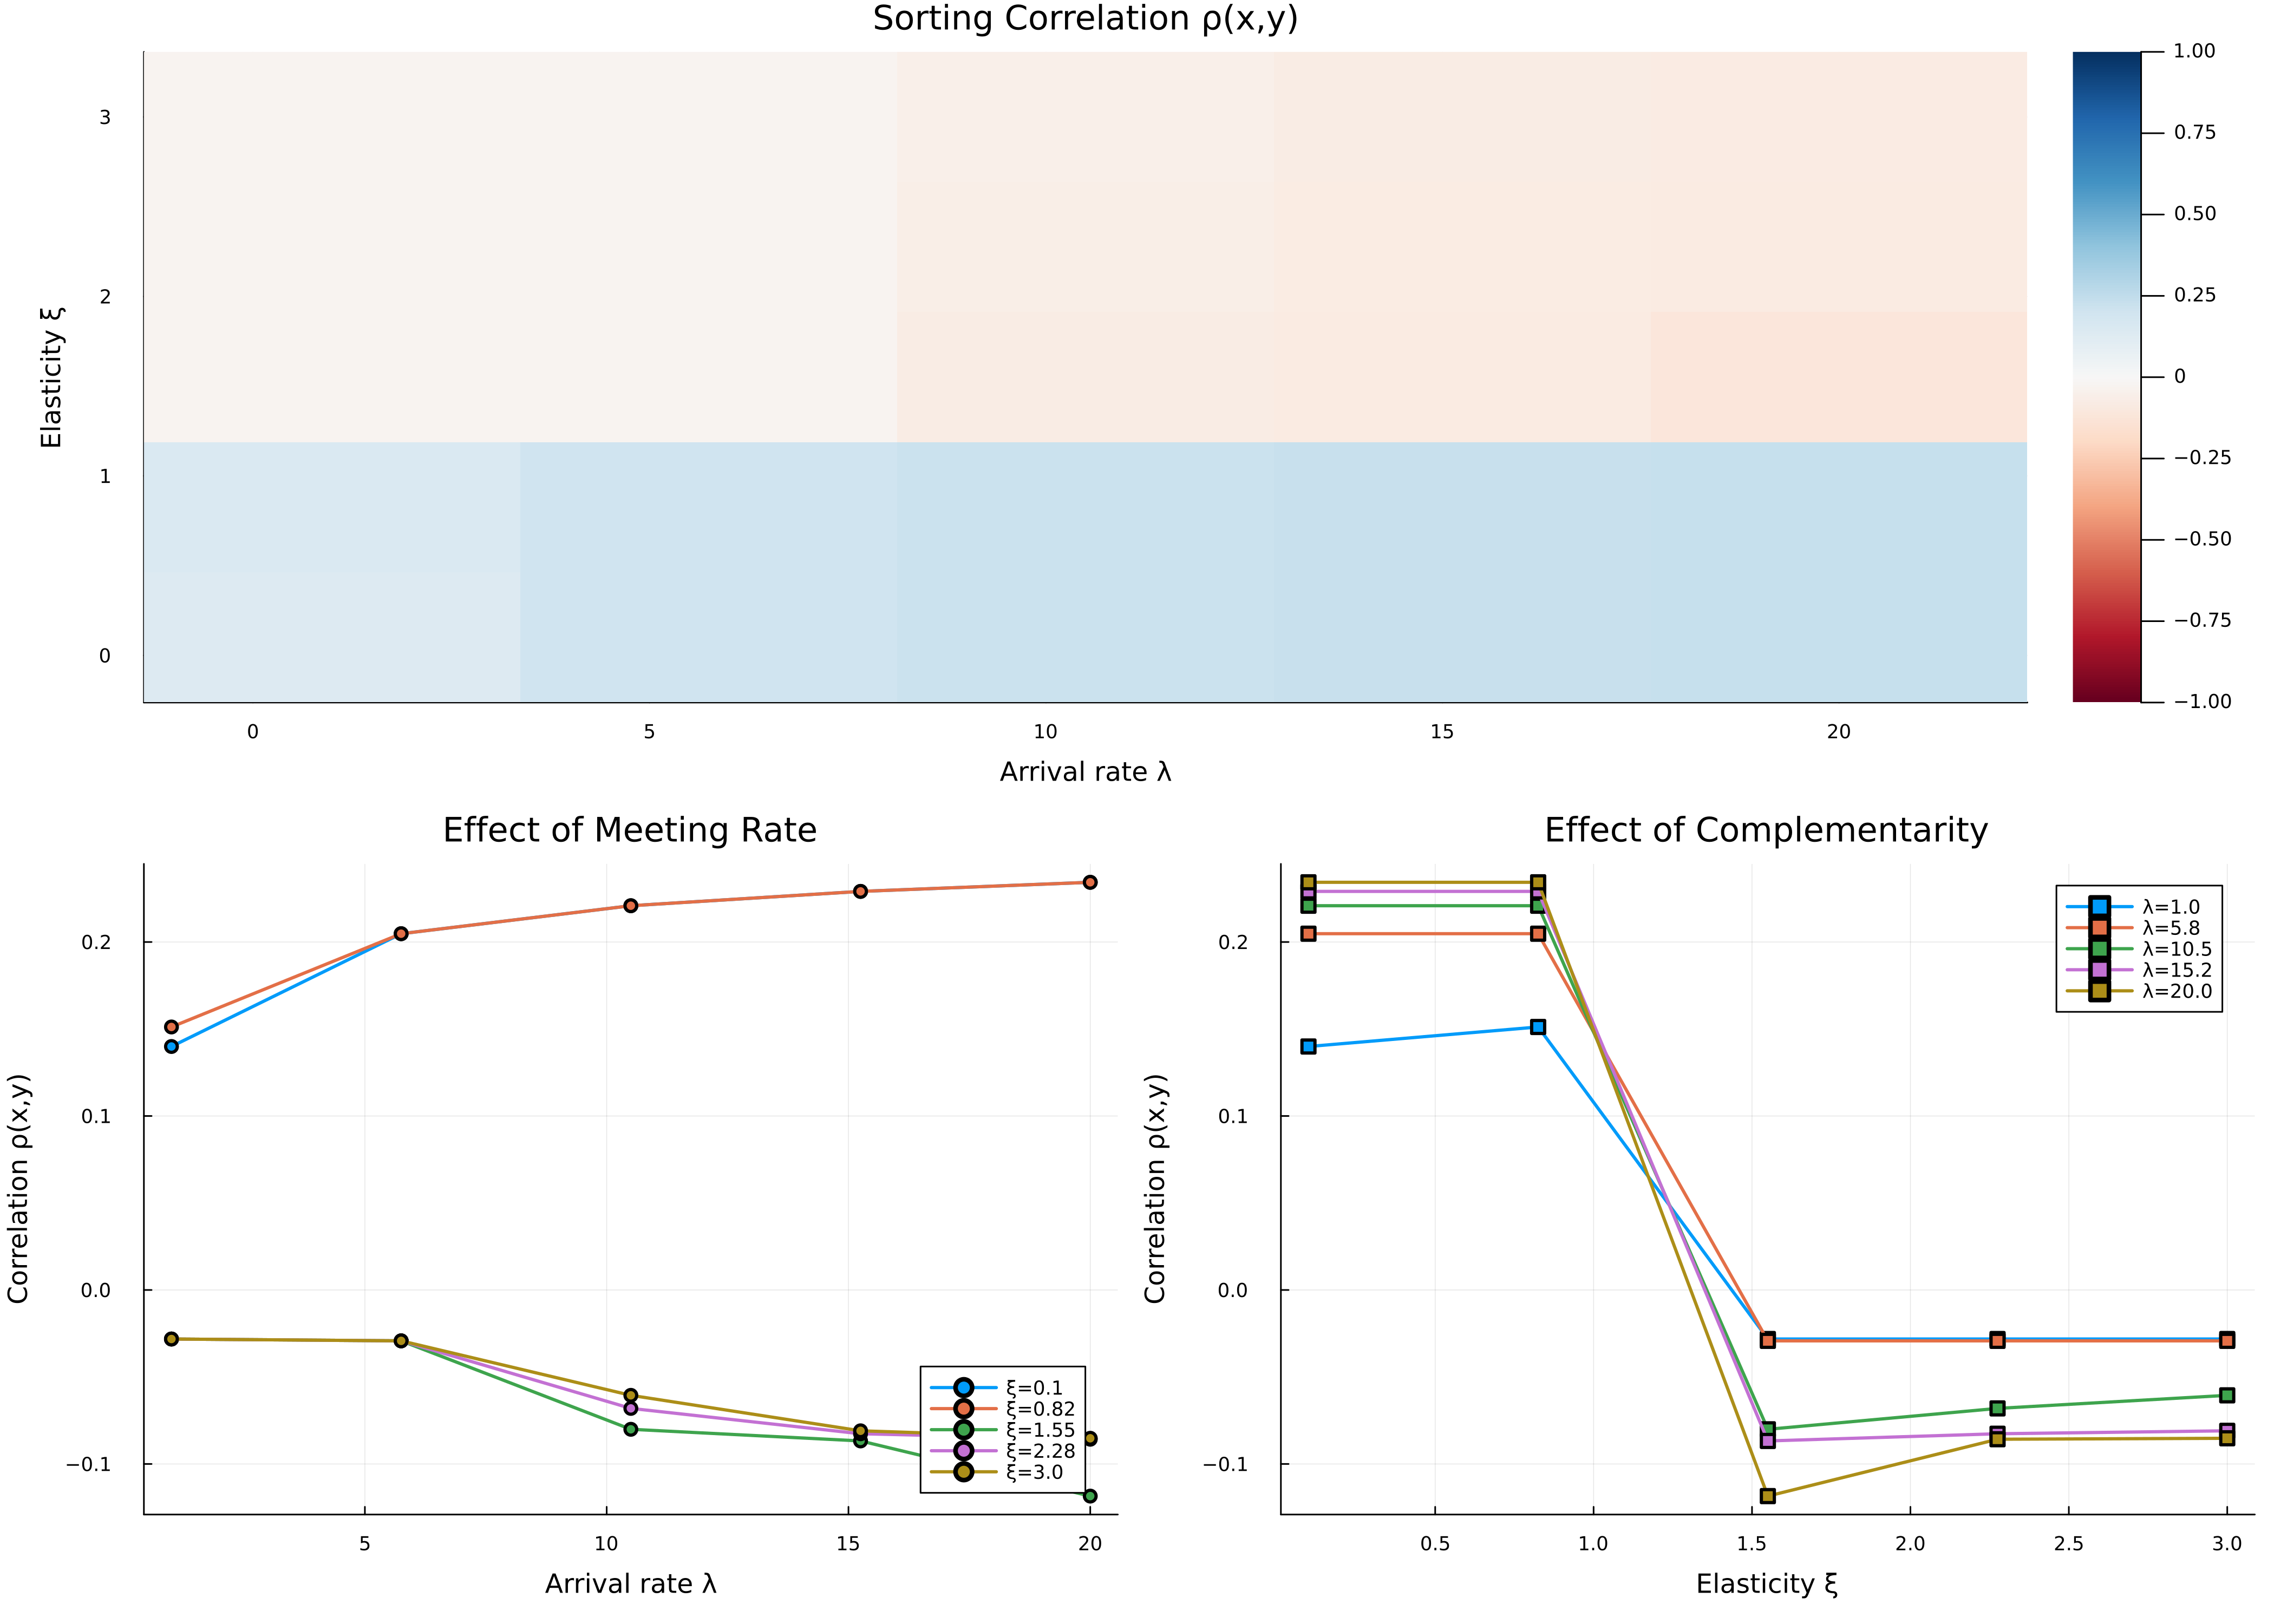

In [ ]:
# Parameter ranges
ξ_values = range(0.1, 3.0, length=5)  # Elasticity of substitution
λ_values = range(1.0, 20.0, length=5)  # Arrival rate

# Storage
correlations = zeros(length(ξ_values), length(λ_values))

# Apply the function over the grid in parallel
for (i, ξ) in enumerate(ξ_values)
    for (j, λ) in enumerate(λ_values)
        # Solve the model with current parameters (suppress output)
        u, v, V_u, V_v, z_bar, p_z_bar, ω_z_bar, α_manual_solution = solve_borovickova_shimer(
            x_grid, y_grid; ζ=ξ, λ=λ, verbose=false
        )
        # Compute sorting correlation
        correlations[i, j] = compute_sorting_correlation(x_grid, y_grid, u, v, z_bar, α_manual_solution)

        # Print progress
        println("Completed: ξ=$(round(ξ, digits=2)), λ=$(round(λ, digits=1)) → ρ_xy=$(round(correlations[i, j], digits=4))")
    end
end

println("\n" * "="^70)
println("RESULTS SUMMARY")
println("="^70)
println("Correlation range: [$(round(minimum(correlations), digits=4)), $(round(maximum(correlations), digits=4))]")
println("="^70)


# Create comprehensive visualization
using Plots

# Heatmap
p1 = heatmap(λ_values, ξ_values, correlations,
        xlabel="Arrival rate λ", 
        ylabel="Elasticity ξ",
        title="Sorting Correlation ρ(x,y)",
        color=:RdBu,
        clims=(-1, 1),
        left_margin=5Plots.mm,
        bottom_margin=5Plots.mm)

# Line plot: effect of λ for different ξ values
p2 = plot(xlabel="Arrival rate λ", 
          ylabel="Correlation ρ(x,y)",
          title="Effect of Meeting Rate",
          legend=:bottomright,
          left_margin=5Plots.mm,
          bottom_margin=5Plots.mm)
for (i, ξ) in enumerate(ξ_values)
    plot!(p2, λ_values, correlations[i, :], 
          label="ξ=$(round(ξ, digits=2))",
          marker=:circle,
          linewidth=2)
end

# Line plot: effect of ξ for different λ values
p3 = plot(xlabel="Elasticity ξ", 
          ylabel="Correlation ρ(x,y)",
          title="Effect of Complementarity",
          legend=:topright,
          left_margin=5Plots.mm,
          bottom_margin=5Plots.mm)
for (j, λ) in enumerate(λ_values)
    plot!(p3, ξ_values, correlations[:, j], 
          label="λ=$(round(λ, digits=1))",
          marker=:square,
          linewidth=2)
end

# Combine plots: p1 on top row, p2 and p3 on bottom row
l = @layout [a{0.5h}; b c]
combined_plot = plot(p1, p2, p3, layout=l, size=(1400, 1000))
savefig(combined_plot, "fig_sorting_analysis.png")
println("Saved: fig_sorting_analysis.png")
Right. 
# Display the plot
combined_plot
